# Numerical modeling workshop (Rijeka, 2022) — fourth day

## Addition of nontrivial topography (hill on the bottom)

$h$ represents deviation of fluid surface from its unperturbed height (which we define to be zero, cf. previous days).

$H$ is a nonchanging depth defining the topography (cf. $H$ in previous days).

\begin{aligned}
\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} &= -g\frac{\partial h}{\partial x}
+fv\,\text,\\
\frac{\partial v}{\partial t} + u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} &= -g\frac{\partial h}{\partial y} - fu\,\text,\\
\frac{\partial h}{\partial t}  + \frac{\partial}{\partial x}\left(u(h+H)\right) &+
\frac{\partial}{\partial y}\left(v(h+H)\right)  = 0\,\text.
\end{aligned}

\begin{aligned}
h+H \overset{(\text{in code})}= \text{H + Hb}
\end{aligned}

\begin{aligned}
\overline{\delta_yh}^y v=\frac 1d\left[ v_{i,j}\frac{(h+H)_{i,j+1} + (h+H)_{i,j}}2 -v_{i,j-1}\frac{(h+H)_{i,j} + (h+H)_{i,j-1}}2\right]
\end{aligned}

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from copy import copy, deepcopy

In [2]:
Deltax = Deltay = d = 200000 # spatial step and the least distance between two cells in the grid
Deltat = 600 # time step
g = 9.81 # gravitational constant
f = 10 ** (-4) # coriolis force constant
Lx = 40000000 # domain size in x direction
Ly = 20000000 # domain size in y direction
SSdistance = 1750000 # distance between source and sink
IM = round(Ly / Deltay) + 1 # number of grid points in y direction
JM = round(Lx / Deltax) + 1 # number of grid points in x direction
# HN = 1000
T_steps = 10 # number of time steps
dh = round(2 * Deltat / 60) # water influx/outflux per time unit
Nmax = Deltat * T_steps # total time

In [3]:
# initialization of variables
U = np.full((IM, JM), 0.05, dtype=float)
V = np.zeros((IM, JM), dtype=float)
H = np.zeros((IM, JM), dtype=float)
UF = np.full((IM, JM), 0.05, dtype=float)
VF = np.zeros((IM, JM), dtype=float)
HF = np.zeros((IM, JM), dtype=float)
Hb = np.full((IM, JM), -1000, dtype=float)

# set the bottom to contain a gaussian-shaped 2D hill
for i in range(IM):
    for j in range(JM):
        Hb[i, j] += math.exp(-((i - 50) / 10) ** 2 - ((j - 100) / 10) ** 2)

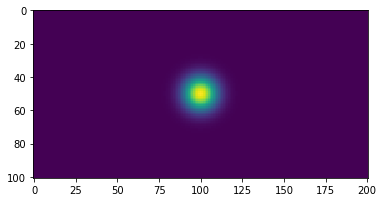

In [4]:
# bottom plot
plt.imshow(Hb, interpolation='none')
plt.show()

n =  0


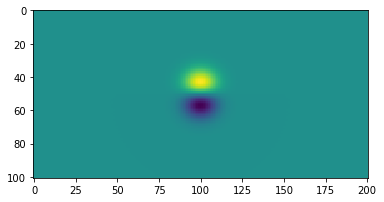

n =  10


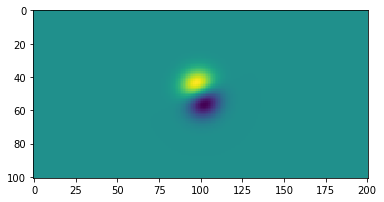

n =  20


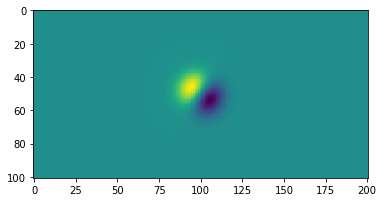

n =  30


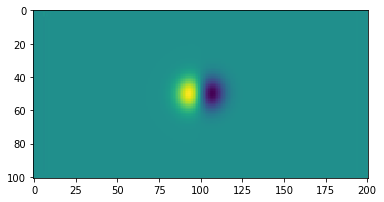

n =  40


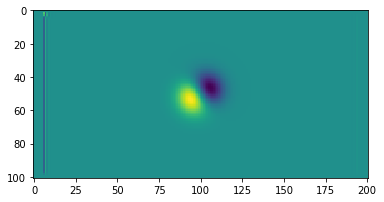

n =  50


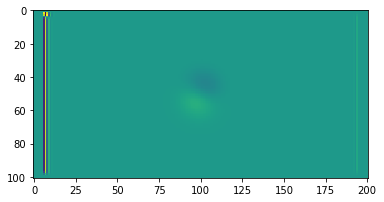

n =  60


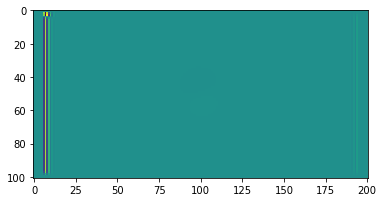

n =  70


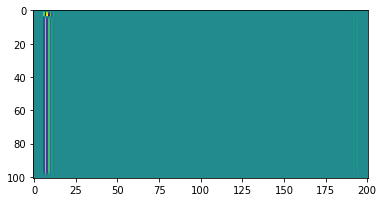

Wall time: 3min 10s


In [5]:
%%time
for n in range(Nmax):
    for i in range(2, IM - 2):
        for j in range(2, JM - 2):
            # discretized differential equations (including advection and hill-shaped bottom)
            UF_cor = -(Deltat / 2) *\
              (U[i, j] * (U[i - 1, j] - U[i + 1, j]) / d + (1 / 4) *\
              (V[i, j] + V[i - 1, j] + V[i, j + 1] + V[i - 1, j + 1]) * ((U[i, j - 1] - U[i, j + 1]) / d))
            VF_cor = -(Deltat / 2) *\
              ((1 / 4) *\
              (U[i, j] + U[i, j - 1] + U[i + 1, j] + U[i + 1, j - 1]) * ((V[i - 1, j] - V[i + 1, j]) / d)\
              + V[i, j] * (V[i, j - 1] - V[i, j + 1]) / d) 
            HF_cor = -(Deltat / 4) *\
            ((U[i, j] + U[i + 1, j]) * ((H[i - 1, j] - H[i + 1, j]) / d) +\
             (V[i, j] + V[i, j + 1]) * ((H[i, j - 1] - H[i, j + 1]) / d))
                        
            #HF[i, j] = H[i, j] -\
            #  (HN * Deltat / d) * ((U[i, j] - U[i + 1, j]) + (V[i, j] - V[i, j + 1])) + HF_cor
            HF[i, j] = -(Deltat / d) * (U[i, j] * (\
              (H[i + 1, j] + Hb[i - 1, j]) + H[i, j] + Hb[i, j]
                                                  ) / 2 -\
              U[i, j] * ((H[i, j] + Hb[i, j]) + (H[i + 1, j] + Hb[i + 1, j])) / 2) +\
                       -(Deltat / d) * (V[i, j] * ((H[i, j - 1] + Hb[i, j - 1]) + (H[i, j] + Hb[i, j])) / 2\
                         -V[i, j + 1] * ((H[i, j] + Hb[i, j]) + (H[i, j + 1] + Hb[i, j + 1])) / 2)
            
            # manual boundary correction
            HF[:, 0] = HF[:, 1] = HF[:, 2] = HF[:, 3] = HF[:, 4] = HF[:, 5] = 0
            HF[:, JM - 1] = HF[:, JM - 2] = HF[:, JM - 3] = HF[:, JM - 4] = HF[:, JM - 5] = HF[:, JM - 6] = 0

            UF[i, j] = U[i, j] -\
              Deltat * ((g / d) *\
               (HF[i - 1, j] - HF[i, j]) + (f / 4) * (V[i, j] + V[i - 1, j] + V[i - 1, j + 1] + V[i, j + 1]))\
              + UF_cor

            VF[i, j] = V[i, j] -\
              Deltat * ((g / d) *\
               (HF[i, j - 1] - HF[i, j]) - (f / 4) * (U[i, j] + U[i, j - 1] + U[i + 1, j - 1] + U[i + 1, j]))\
              + VF_cor

            U = deepcopy(UF)
            V = deepcopy(VF)
            H = deepcopy(HF)
            
            # periodic boundary conditions
            U[:, 0] = UF[:, JM - 2]
            U[:, 1] = UF[:, JM - 1]
            V[:, 0] = VF[:, JM - 2]
            V[:, 1] = VF[:, JM - 1]
            H[:, 0] = HF[:, JM - 2]
            H[:, 1] = HF[:, JM - 1]
            
            # force increase in u
            if n < 10:
                U = U + 0.05
            
    if n % 10 == 0:
        print('n = ', n)
        plt.imshow(H, interpolation='none')
        plt.show()

    if n == 70:
        break

TODO: find the source of numerical instability, discussion of boundary effects killing off everything else

General advice: upon obtaining something manifestly nonphysical or nebulous, it is advised to simulate a more elementary version of the problem (e.g. no initial velocity) and then add the elements one by one.

A significant problem with our periodic conditions in $x$ direction is the fact that in boundary grid cells there exist $h$, $u$ and $v$ that fall outside of the grid. For example (with FORTRAN indexing, starting from $1$):
h u h u ...  h u h u
1 1 2 2 ...  IM-1 IM-2

$u_2 = u_{IM-2}$

$u_1 = u_{IM-1}$

$h_2 = h_{IM}$

$h_1 = h_{IM-1}$

However, if we manually correct some of the boundary conditions, we can easily expand the time before problems occur:

In [6]:
# initialization of variables
U = np.full((IM, JM), 0.05, dtype=float)
V = np.zeros((IM, JM), dtype=float)
H = np.zeros((IM, JM), dtype=float)
UF = np.full((IM, JM), 0.05, dtype=float)
VF = np.zeros((IM, JM), dtype=float)
HF = np.zeros((IM, JM), dtype=float)
Hb = np.full((IM, JM), -1000, dtype=float)

# set the bottom to contain a gaussian-shaped 2D hill
for i in range(IM):
    for j in range(JM):
        Hb[i, j] += math.exp(-((i - 50) / 10) ** 2 - ((j - 100) / 10) ** 2)

n =  0


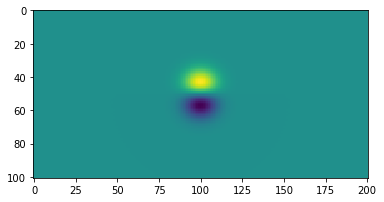

n =  10


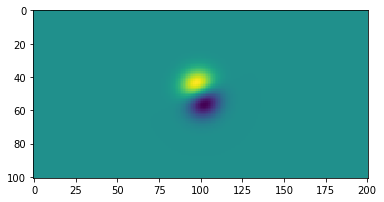

n =  20


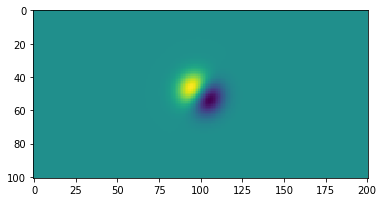

n =  30


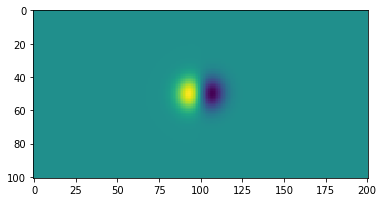

n =  40


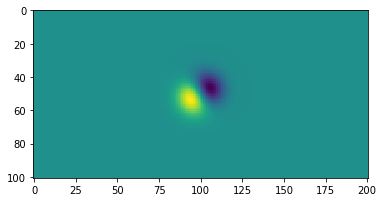

n =  50


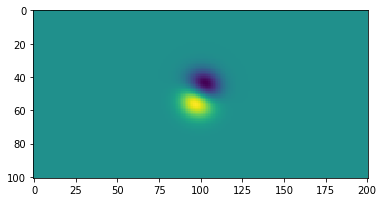

n =  60


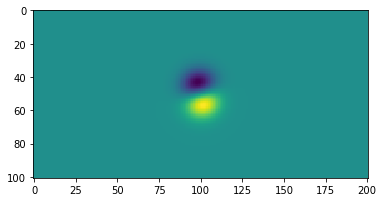

n =  70


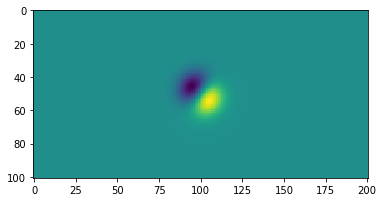

n =  80


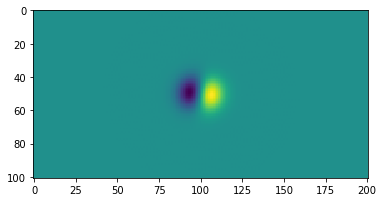

n =  90


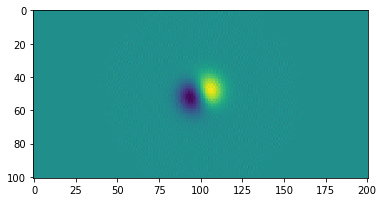

n =  100


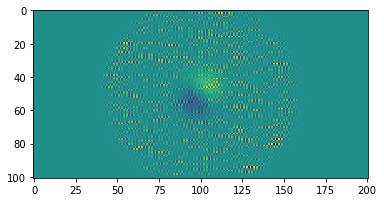

n =  110


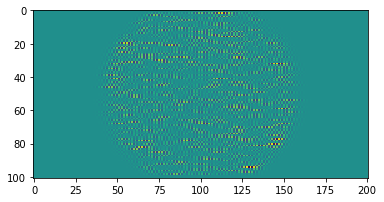

Wall time: 5min 16s


In [7]:
%%time
for n in range(Nmax):
    for i in range(2, IM - 2):
        for j in range(2, JM - 2):
            # discretized differential equations (including advection and hill-shaped bottom)
            UF_cor = -(Deltat / 2) *\
              (U[i, j] * (U[i - 1, j] - U[i + 1, j]) / d + (1 / 4) *\
              (V[i, j] + V[i - 1, j] + V[i, j + 1] + V[i - 1, j + 1]) * ((U[i, j - 1] - U[i, j + 1]) / d))
            VF_cor = -(Deltat / 2) *\
              ((1 / 4) *\
              (U[i, j] + U[i, j - 1] + U[i + 1, j] + U[i + 1, j - 1]) * ((V[i - 1, j] - V[i + 1, j]) / d)\
              + V[i, j] * (V[i, j - 1] - V[i, j + 1]) / d) 
            HF_cor = -(Deltat / 4) *\
            ((U[i, j] + U[i + 1, j]) * ((H[i - 1, j] - H[i + 1, j]) / d) +\
             (V[i, j] + V[i, j + 1]) * ((H[i, j - 1] - H[i, j + 1]) / d))
                        
            #HF[i, j] = H[i, j] -\
            #  (HN * Deltat / d) * ((U[i, j] - U[i + 1, j]) + (V[i, j] - V[i, j + 1])) + HF_cor
            HF[i, j] = -(Deltat / d) * (U[i, j] * (\
              (H[i + 1, j] + Hb[i - 1, j]) + H[i, j] + Hb[i, j]
                                                  ) / 2 -\
              U[i, j] * ((H[i, j] + Hb[i, j]) + (H[i + 1, j] + Hb[i + 1, j])) / 2) +\
                       -(Deltat / d) * (V[i, j] * ((H[i, j - 1] + Hb[i, j - 1]) + (H[i, j] + Hb[i, j])) / 2\
                         -V[i, j + 1] * ((H[i, j] + Hb[i, j]) + (H[i, j + 1] + Hb[i, j + 1])) / 2)
            
            # manual boundary correction
            HF[:, 0] = HF[:, 1] = HF[:, 2] = HF[:, 3] = HF[:, 4] = HF[:, 5] = 0
            
            HF[:, 6] = HF[:, 11]
            HF[:, 7] = HF[:, 12]
            HF[:, 8] = HF[:, 13]
            HF[:, 9] = HF[:, 14]
            HF[:, 10] = HF[:, 15]
            
            HF[:, JM - 1] = HF[:, JM - 2] = HF[:, JM - 3] = HF[:, JM - 4] = HF[:, JM - 5] = HF[:, JM - 6] = 0
            
            HF[:, JM - 7] = HF[:, JM - 12]
            HF[:, JM - 8] = HF[:, JM - 13]
            HF[:, JM - 9] = HF[:, JM - 14]
            HF[:, JM - 10] = HF[:, JM - 15]
            HF[:, JM - 11] = HF[:, JM - 16]

            UF[i, j] = U[i, j] -\
              Deltat * ((g / d) *\
               (HF[i - 1, j] - HF[i, j]) + (f / 4) * (V[i, j] + V[i - 1, j] + V[i - 1, j + 1] + V[i, j + 1]))\
              + UF_cor

            VF[i, j] = V[i, j] -\
              Deltat * ((g / d) *\
               (HF[i, j - 1] - HF[i, j]) - (f / 4) * (U[i, j] + U[i, j - 1] + U[i + 1, j - 1] + U[i + 1, j]))\
              + VF_cor

            U = deepcopy(UF)
            V = deepcopy(VF)
            H = deepcopy(HF)
            
            # periodic boundary conditions
            U[:, 0] = UF[:, JM - 2]
            U[:, 1] = UF[:, JM - 1]
            V[:, 0] = VF[:, JM - 2]
            V[:, 1] = VF[:, JM - 1]
            H[:, 0] = HF[:, JM - 2]
            H[:, 1] = HF[:, JM - 1]
            
            # force increase in u
            if n < 10:
                U = U + 0.05

    if n % 10 == 0:
        print('n = ', n)
        plt.imshow(H, interpolation='none')
        plt.show()
    if n == 110:
        break

TODO: remove as much manual boundary corrections as possible, add correct boundary conditions (cf. previous cells)